&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next step: Extract video frames](../inference/extract_video_frames.ipynb)

# Evaluate ungulate detection model
This notebook generates information and plots that can help you evaluate the detection model for the Kenyan ungulates example. 

In [1]:
import contextlib
import glob
import io
import json
import os
import random
import time

from fvcore.common.file_io import PathManager
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import torch 

import detectron2
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.structures import BoxMode

# local .json file with local path info
geladas_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(
    os.path.join(local_paths['overhead_functions_path'],
                 "detectron2_classes")
)

from DetectionDatasetMapper import DetectionDatasetMapper
from PrecisionRecallEvaluator import PrecisionRecallEvaluator
from GroundtruthVisualizer import GroundtruthVisualizer

sys.path.append(local_paths['overhead_functions_path'])

from print_instances_class_histogram import print_instances_class_histogram

In [2]:
detectron2.__version__

'0.2.1'

In [3]:
# Local folder with annotated images and subfolder containing train.json
# and val.json files
annotations_folder = local_paths['annotations_folder'] 
# This the name of the subfolder that contains that annotation .jsons
annotation_set_name = "annotations-clean-name-pruned"

### Prepare to load already trained model

In [5]:
# Model name to use saved in the output folder
model_name = "full-resolution-model_maxiter-133600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"
yaml_file = os.path.join("output", model_name, 'config.yaml')
print(yaml_file)

# Configure model for validation
cfg = get_cfg()
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(cfg.OUTPUT_DIR, "best-model-config-iter-*.pth"))
)[-1]
print(weights_path)
cfg.MODEL.WEIGHTS = os.path.join(weights_path)

output/full-resolution-model_maxiter-133600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/config.yaml
./output/full-resolution-model_maxiter-133600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/best-model-config-iter-96859-loss-0.4168833134190948.pth


### Load training and validation data

In [6]:
train_json = os.path.join(annotations_folder, annotation_set_name, 'train.json') 
val_json = os.path.join(annotations_folder, annotation_set_name, 'val.json')

register_coco_instances("train", {}, train_json, annotations_folder)
register_coco_instances("val", {}, val_json, annotations_folder)

In [7]:
train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")

### Get stats on training and validation data

In [8]:
train_metadata = MetadataCatalog.get("train")
train_metadata.get("thing_classes")

['zebra', 'gazelle', 'wbuck', 'buffalo', 'other']

In [9]:
num_train_images = len(train_dicts)
num_val_images = len(val_dicts)
print(f"{num_train_images} training images \n"
      + f"{num_val_images} validation images")

1340 training images 
286 validation images


In [10]:
print("\nTrain frames:")
print_instances_class_histogram(train_dicts, train_metadata.get("thing_classes"), num_frames=True)
print("\nTrain annotations:")
print_instances_class_histogram(train_dicts, train_metadata.get("thing_classes"), num_frames=False)
print("\nValidation frames:")
print_instances_class_histogram(val_dicts, train_metadata.get("thing_classes"), num_frames=True)
print("\nValidation annotations:")
print_instances_class_histogram(val_dicts, train_metadata.get("thing_classes"), num_frames=False)


Train frames:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   zebra    | 1007         |  gazelle   | 378          |   wbuck    | 63           |
|  buffalo   | 192          |   other    | 172          |            |              |
|   total    | 1812         |            |              |            |              |

Train annotations:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   zebra    | 14315        |  gazelle   | 4830         |   wbuck    | 498          |
|  buffalo   | 6192         |   other    | 854          |            |              |
|   total    | 26689        |            |              |            |              |

Validation frames:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |

### Choose data set to use

In [11]:
dataset_name = "val"
mapper = DetectionDatasetMapper(cfg, is_train=False, calc_val_loss=False)
loader = build_detection_test_loader(cfg, dataset_name, mapper)

### Visualize output from model for a few random demo files

/home/golden/detectron2aug16/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


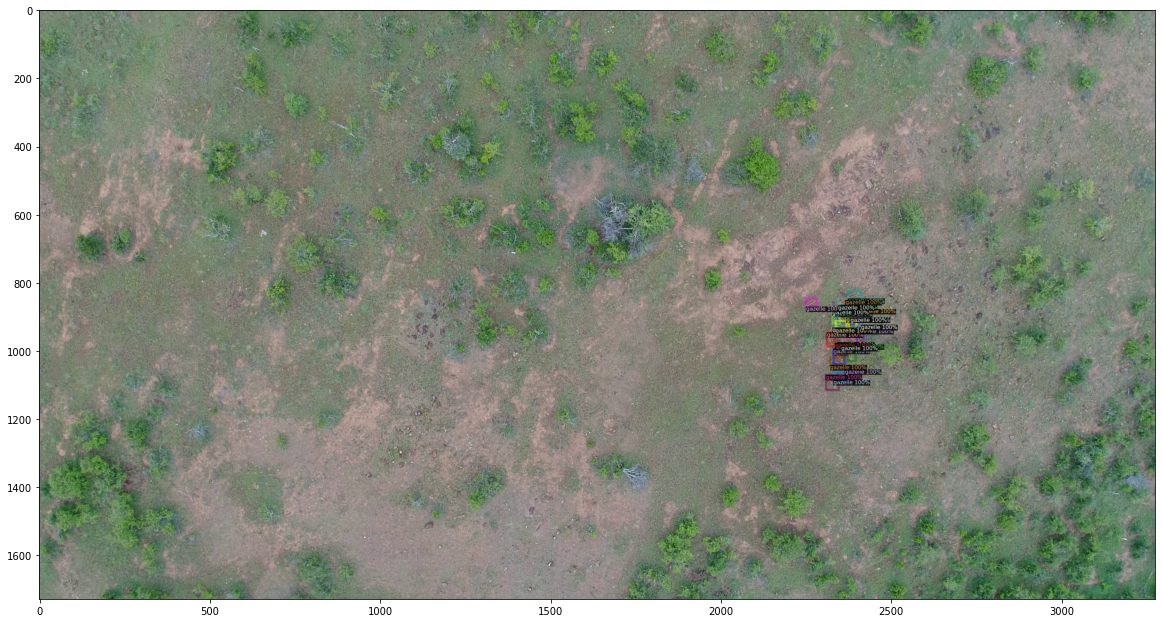

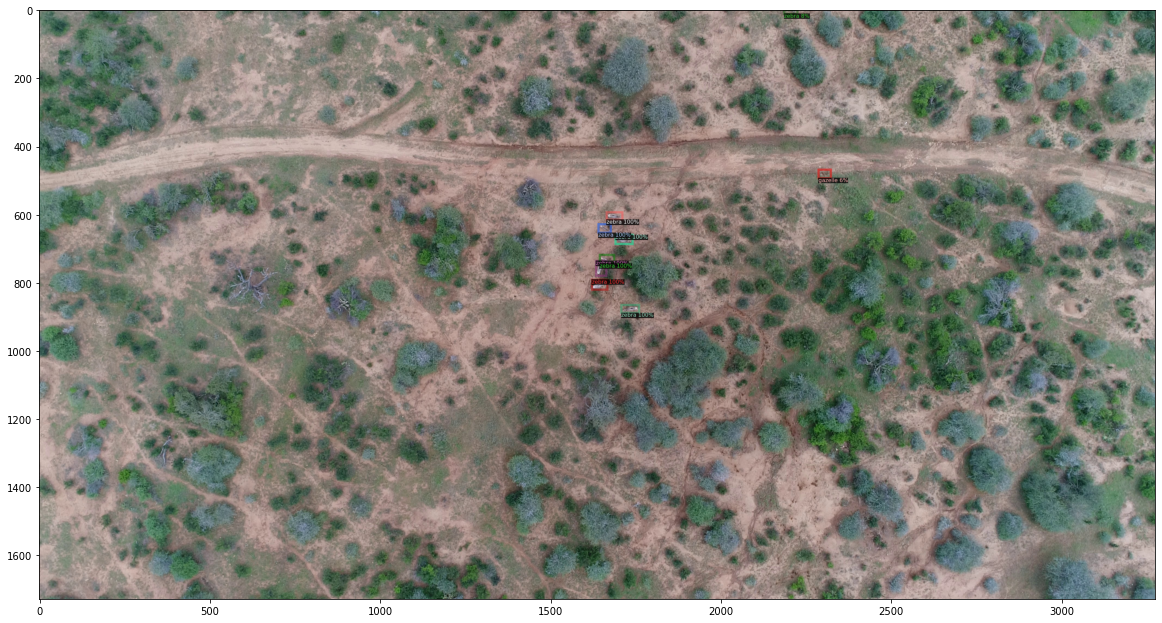

In [12]:
cfg.DATASETS.TEST = (dataset_name, )
predictor = DefaultPredictor(cfg)

for d in random.sample(val_dicts, 2):
    im = utils.read_image(
        d["file_name"], format=cfg.INPUT.FORMAT
    )
    outputs = predictor(im)
    v = GroundtruthVisualizer(im[:, :, ::],
                   metadata=train_metadata,
                   scale=0.8,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,20))
    plt.imshow(v.get_image()[:, :, ::-1])

### Get precision and recall stats across entire validation set

In [13]:
# Check model performance on the validation set
evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False)
evaluator.reset()

cfg.DATASETS.TEST = (dataset_name, )

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')
        outputs = model(batch)
        evaluator.process(batch, outputs)             

coco_result = evaluator.evaluate()

processed batch 0
processed batch 50
processed batch 100
processed batch 150
processed batch 200
processed batch 250
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.10 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.872
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95

In [14]:
coco_result['bbox']['res']

{'AP': 71.11424773432991,
 'AP50': 98.01943422671752,
 'AP75': 87.16021123794494,
 'APs': 46.85590643724251,
 'APm': 71.4274116079585,
 'APl': 49.44310633943075,
 'AP-zebra': 70.81384679059416,
 'AP-gazelle': 67.43217729767149,
 'AP-wbuck': 82.24328158872014,
 'AP-buffalo': 66.39523638464065,
 'AP-other': 68.68669661002306}

### Plot precision recall curves for each object class

Max detections: 100


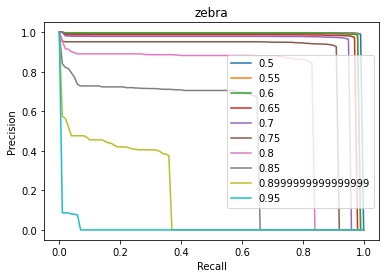

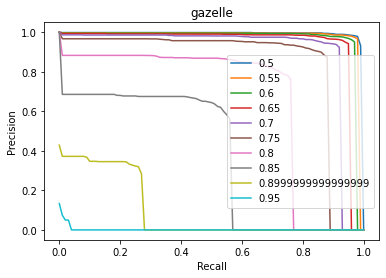

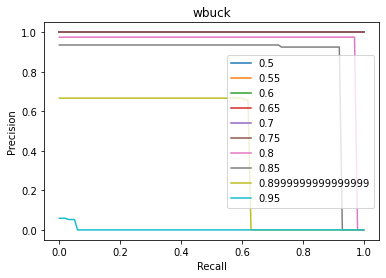

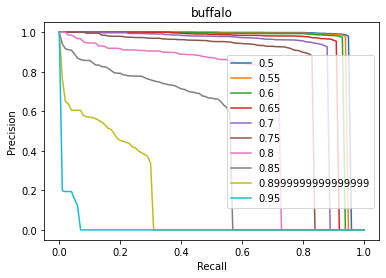

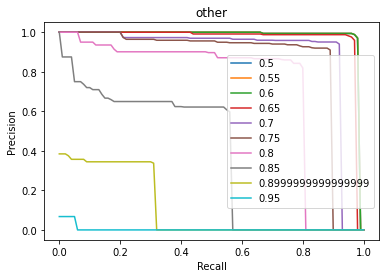

In [15]:
# See https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
# for details about the output

params = coco_result['bbox']['params']
precision = coco_result['bbox']['precision']

max_dets_ind = 2
print(f"Max detections: {params.maxDets[max_dets_ind]}")

area_rng_ind = 0 # 0 corresponds to all detection sizes

for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    plt.figure()
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, 
                 precision[iou_ind, :, obj_class, area_rng_ind, max_dets_ind], 
                 label=iou_thrsh)
    plt.legend()
    plt.title(train_metadata.get("thing_classes")[obj_class])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

### Get precision recall stats for specific IOU and threshold values

In [16]:
# default iou thresh values are 
# [0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]
iou_thresh_ind = 2
print(f"Using an iou threshold of {params.iouThrs[iou_thresh_ind]}")

score_thresh = .6
print(f"Using score threshold of {score_thresh}")

max_dets_ind = 2

area_rng_ind = 0 # 0 corresponds to all detection sizes
print(f"Using area size range {params.areaRng[area_rng_ind]}")

print("")

scores = coco_result['bbox']['scores']

for obj_class, obj_name in enumerate(train_metadata.get("thing_classes")):  
    above_thresh = np.argwhere(
        scores[iou_thresh_ind, :, obj_class, area_rng_ind, max_dets_ind] >= score_thresh)
    if len(above_thresh) == 0:
        print(f"{obj_name:8}: recall: {np.nan:1.2f}, precision: {np.nan:1.3f}")
        continue
    max_ind = np.max(above_thresh)
    print(f"{obj_name:8}: recall: {params.recThrs[max_ind]:1.2f}, "
          f"precision: {precision[iou_thresh_ind, max_ind, obj_class, area_rng_ind, max_dets_ind]:1.3f}")

Using an iou threshold of 0.6
Using score threshold of 0.6
Using area size range [0, 10000000000.0]

zebra   : recall: 0.98, precision: 0.985
gazelle : recall: 0.97, precision: 0.951
wbuck   : recall: 1.00, precision: 1.000
buffalo : recall: 0.93, precision: 0.975
other   : recall: 0.98, precision: 0.971


### P.S. can also run validation with visualization

In [ ]:
# Preparing for COCO style validation
dataset_metadata = MetadataCatalog.get(dataset_name)
json_file = PathManager.get_local_path(dataset_metadata.json_file)
with contextlib.redirect_stdout(io.StringIO()):
    coco_api = COCO(json_file)
    
coco_api.createIndex()

In [ ]:
# Check model performance on the validation set
evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False)
evaluator.reset()

show_ims = False
show_gts = False

cfg.DATASETS.TEST = (dataset_name, )

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

pred_dicts = val_dicts
num_frames = len(pred_dicts)


all_outputs = []

t = time.time()
with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')

        outputs = model(batch)
        

        all_outputs.extend(outputs)
    
        evaluator.process(batch, outputs)
        if show_ims:   
            for ind, output in enumerate(outputs):
                im = (
                    np.transpose(batch[0]['image'].numpy(), (1, 2, 0))
                ).astype(int)
                
                im_id = batch[ind]['image_id']

                gts=coco_api.loadAnns(coco_api.getAnnIds(imgIds=[im_id]))
                anno_dict = {}
                for gt in gts:
                    gt['bbox_mode'] = BoxMode.XYWH_ABS
                anno_dict['annotations'] = gts
                
                scale = 0.8
                if show_gts:
                    v = GroundTruthVisualizer(im,
                               metadata=train_metadata,
                               scale=1.0,
                    )
                    v_gt = v.draw_dataset_dict(anno_dict)
                    im = v_gt.get_image()
                    plt.figure(figsize=(20, 20))
                    plt.imshow(v_gt.get_image()[:, :, ::-1])
                v = Visualizer(im,
                               metadata=train_metadata,
                               scale=scale,
                )
                v_im = v.draw_instance_predictions(output["instances"].to("cpu"))
                
                plt.figure(figsize=(20, 20))
                plt.imshow(v_im.get_image()[:, :, ::-1])
                
                
        if batch_num >= 1000:
            print(f'batch {batch_num}')
            break
total_time = time.time() - t
print(f"fps: {num_frames/total_time}, total_time {total_time}, num_frames {num_frames}")

coco_result = evaluator.evaluate()

&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next step: Extract video frames](../inference/extract_video_frames.ipynb)